### Note - custom version of pandas needed

In [1]:
import os
notebook_dir = os.getcwd()
os.chdir('/Users/adamamiller/software/git_repos/pandas')
import pandas as pd
os.chdir(notebook_dir)

import glob

import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u

from scipy.stats import median_abs_deviation

import gc

os.chdir(os.path.dirname(notebook_dir))
from bts_phot import calibrate_fps

%matplotlib notebook

# ZTF fps

The IPAC forced photometry service (fps) produces fixed-position, "forced" photometry on existing difference images in the ZTF IPAC archive. The [IPAC fps documentation](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf) includes all the relevant details, here we provide a brief summary of the fps before describing the BTS light curve processing procedure.

 The fps takes a user-supplied position (and date range) and queries the ZTF subtraction image database for all images that contain the specified coordinates. PSF photometry is then measured at the specified position using the already-determined PSF model for the subtraction image. Results from these measurements are then returned in a standard IPAC table. There are many columns in the table, some of which are useful for flagging unreliable flux measurements, but the most important columns are: `jd`, `filter`, `zpdiff`, `forcediffimflux`, and `forcediffimfluxunc`.

While the fps provides both a zero-point and flux measurement, potential systematic offsets in the gain of the reference and new science images requires correction prior to measuring a calibrated flux. 

# BTS light curves

IPAC fps output requires a "baseline correction" ([see the docs](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf)). This baseline is best determined using a large (>~ 25) statistical sample of subtraction images that do not include emission from the transient of interest. Most transients have a suitable set of "pre-transient" images, but a significant fraction (e.g., many ZTF discoveries from 2018) require images taken long after the transient has faded. A suitable baseline can be identified visually, though with thousands of BTS transients we automate this procedure.

### Time of maximum

For individual transients we determine the time of maximum by calculating a running median with a 14 day window for every field + filter + chip + quadrant combination (designated `fcqfid` see [Yao et al. (2019)](http://dx.doi.org/10.3847/1538-4357/ab4cf5)) in the fps products. The final time of maximum is determined by taking the mean time of maximum for any g-band or r-band fcqfids taken on the primary ZTF observing grid (see [Bellm et al. (2018)](http://dx.doi.org/10.1088/1538-3873/aaecbe) for more details on the primary and secondary ZTF observing grids).

### Baseline correction

By default, the baseline for each `fcqfid` is determined using observations obtained more than *100 d prior* to the time of maximum light. This threshold is extremely conservative as very few transients have a rise time >100 d. If there are not enough suitable pre-transient observations (i.e., < 25) to measure the baseline correction, the baseline is determined using observations obtained more than *500 d after* the time of maximum light. Again this choice is conservative, though there are transients that have long rise times or that can be detected for years after they are discovered. The baseline correction `C` is calculated via the median `forcediffimflux` value in the baseline region.

We report the total number of observations used to calculate `C` and whether the baseline is measured in observations before or after maximum light. We advise caution when using light curves with few baseline observations (< ~25), and do not provide baseline corrections when there are < 10 observations in the baseline region. If there are > 25 pre-maximum baseline observations or (> 10 pre-maximum AND < 25 post-maximum baseline observations then we use the pre-maximum baseline. Otherwise we use the post-maximum baseline. Pre-maximum baseline measurements are always better than post-maximum measurements because there is always some transient emission present at late times (emission that is statistically insignificant after 500 d, hopefully). 

<IPython.core.display.Javascript object>


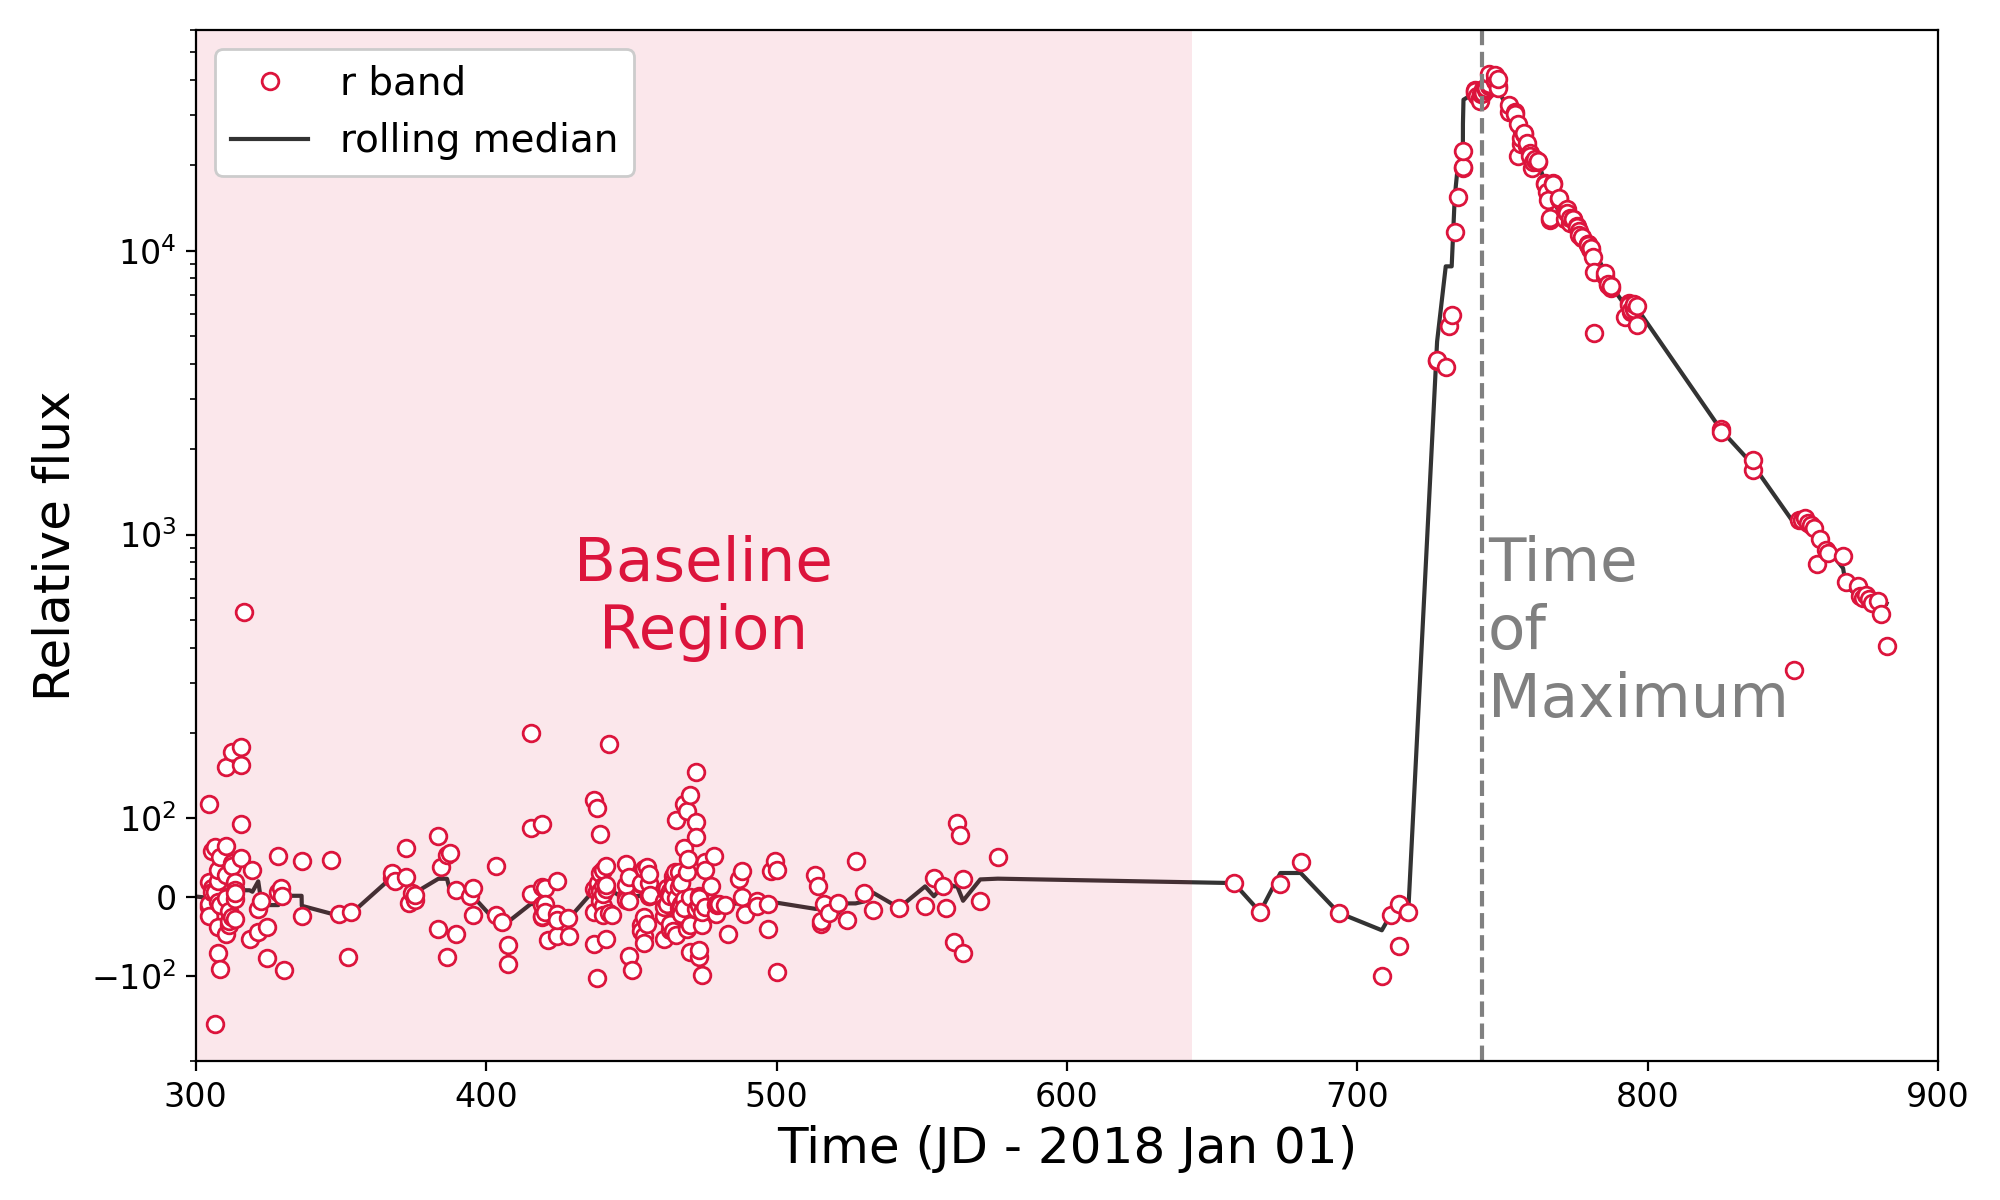

In [2]:
fp_df = calibrate_fps.read_ipac_fps('./fps_data/forcedphotometry_ZTF19adcecwu_lc.txt.gz')

# make a plot showing baseline detection
jdstart = 2458119.5 # 2018 Jan 01
t_peak = 2458862.4618663252
r_band = np.where(fp_df.fcqfid.values == 8191332)

roll_med = fp_df.iloc[r_band].forcediffimflux.rolling('14D', center=True).median().values


fig, ax = plt.subplots(figsize=(10,6))


ax.plot(fp_df.jd.values[r_band] - jdstart, 
        fp_df.forcediffimflux.values[r_band],
        'o', mec='Crimson', mfc='white', 
        label='r band')

ax.plot(fp_df.jd.values[r_band] - jdstart, 
        roll_med, color='0.2', 
        label='rolling median', zorder=-10)


ax.axvline(x = t_peak - jdstart, 
           color = '0.5', ls = '--')
ax.axvspan(0, t_peak - jdstart - 100, color='Crimson', alpha=0.1, lw=0)

ax.set_xlim(300, 900)
ax.set_ylim(-200,6e4)
ax.set_yscale('symlog', 
              linthresh=100, 
              linscale=0.25, 
              subs=[2, 3, 4, 5, 6, 7, 8, 9])
ax.legend(loc=2, fontsize=14, framealpha=1)
ax.text(475, 1e3, 'Baseline\nRegion', 
        ha='center',va='top',
        fontsize=22, color='Crimson')
ax.text(t_peak - jdstart+2, 1e3, 'Time\nof\nMaximum', 
        ha='left',va='top',
        fontsize=22, color='0.5')
ax.set_ylabel('Relative flux', fontsize=18)
ax.set_xlabel('Time (JD - 2018 Jan 01)', fontsize = 18)
ax.tick_params(axis='both', labelsize=12)
fig.tight_layout()
fig.savefig('./images/baseline_max.jpg')

In [7]:
!pwd

/Users/adamamiller/astronomy/ZTF/ztf_forced_phot


### Scaling the uncertainties

Following the recommendation in the [fps documentation](http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf), we re-scale the uncertainties of all observations based on the chi-squared distribution of observations in the baseline region. In brief, flux measurements in an "empty" patch of sky should follow a gaussian distribution and "excess" scatter points to some systematic uncertainty that has not been properly quantified (subtractions near galaxy nuclei often exhibit such excess scatter). If the chi-squared distribution is >1, then the uncertainties *of all observations* are multiplied by the square root of the reduced chi squared in the baseline region (see also [Yao et al. (2019)](http://dx.doi.org/10.3847/1538-4357/ab4cf5)).